In [1]:
import numpy as np
from cmeutils.sampling import is_equilibrated, equil_sample
from cmeutils.dynamics import msd_from_gsd
import unyt as u
from unyt import Unit
import signac
import gsd.hoomd
import matplotlib.pyplot as plt
import os

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.
****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other     *
* Uses of JAX in the same code.          *
******************************************



In [2]:
project = signac.get_project("../validation/")
job_filter = {"remove_hydrogens": True, "remove_charges": False, "pressure": 0.0013933}

/home/erjank_project/chrisjones/1-PPS-MSIBI/pps-msibi/validation/workspace/35790eaab025c2f0dc73ff104b4c76f6 1.7


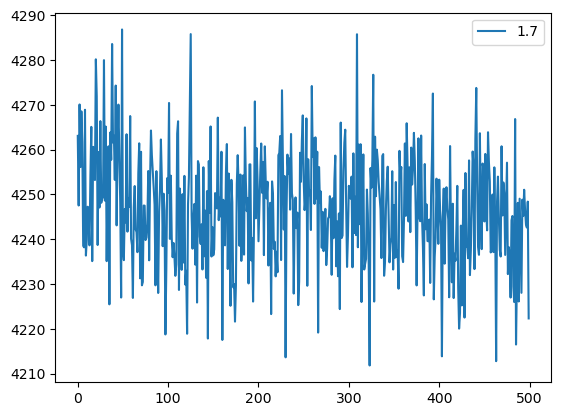

In [23]:
job_filter = {
    "remove_hydrogens": False,
    "remove_charges": False,
    "pressure": 0.0013933,
    "doc.n_runs": 2,
    "doc.equilibrated": True,
    "kT": 1.7
}
for job in project.find_jobs(filter=job_filter):
    data = np.genfromtxt(job.fn("log2.txt"), names=True)
    temp = data["mdcomputeThermodynamicQuantitieskinetic_temperature"]
    vol = data["mdcomputeThermodynamicQuantitiesvolume"]
    pressure = data["mdcomputeThermodynamicQuantitiespressure"]
    pe = data["mdcomputeThermodynamicQuantitiespotential_energy"]
    #plt.plot(vol[3600:])
    #plt.plot(temp[3950:])
    plt.plot(vol[-500:], label=job.sp.kT)
    print(job.path, job.sp.kT)

plt.legend()

In [5]:
job_filter = {"remove_hydrogens": False, "remove_charges": False, "pressure": 0.0013933, "doc.n_runs": 2, "doc.equilibrated": False}
for job in project.find_jobs(filter=job_filter):
    data = np.genfromtxt(job.fn("log2.txt"), names=True)
    vol = data["mdcomputeThermodynamicQuantitiesvolume"]
    pe = data["mdcomputeThermodynamicQuantitiespotential_energy"]
    #sample_idx = len(vol)//2
    sample_idx = 0
    vol_eq = is_equilibrated(vol[sample_idx:], threshold_fraction=0.20, threshold_neff=100)[0]
    pe_eq = is_equilibrated(pe[sample_idx:], threshold_fraction=0.20, threshold_neff=100)[0]
    print(job.sp.kT, vol_eq, pe_eq)
    if all([vol_eq, pe_eq]):
        print("equilibrated")
        job.doc.equilibrated = True
    print()

2.4 False True

1.5 True True
equilibrated

2.6 False True

1.3 True True
equilibrated

1.8 True True
equilibrated

1.6 False True

2.2 True True
equilibrated

1.9 True True
equilibrated

1.7 True True
equilibrated



In [8]:
job_filter = {"remove_hydrogens": False, "remove_charges": False, "pressure": 0.0013933, "doc.n_runs": 2, "doc.equilibrated": True}
for job in project.find_jobs(filter=job_filter):
    #if job.doc.volume_sampled: 
    #    continue
    data = np.genfromtxt(job.fn("log2.txt"), names=True)
    vol = data["mdcomputeThermodynamicQuantitiesvolume"]
    #sample_idx = len(vol)//2
    sample_idx = 0
    try:
        uncorr_sample, uncorr_indices, prod_start, Neff = equil_sample(
            vol[sample_idx:], threshold_fraction=0.20, threshold_neff=100
        )
    except:
        print(job.id)
        continue
    vol_nm = uncorr_sample * (job.doc.ref_length**3) * Unit(f"{job.doc.ref_length_units}**3")
    vol_cm = vol_nm.to("cm**3")
    job.doc.avg_vol = np.mean(vol_cm.value)
    job.doc.vol_std = np.std(vol_cm.value)
    #np.savetxt(job.fn("vol_sample_indices.txt"), uncorr_indices + sample_idx)
    np.savetxt(job.fn("vol_cc.txt"), vol_cm.value)
    with gsd.hoomd.open(job.fn("restart.gsd")) as traj:
        snap = traj[0]
        reduced_mass = sum(snap.particles.mass)
        mass_amu = reduced_mass * job.doc.ref_mass * Unit(job.doc.ref_mass_units)
        mass_g = mass_amu.to("g")
        job.doc.mass_g = mass_g.value
    job.doc.avg_density = job.doc.mass_g / job.doc.avg_vol
    job.doc.density_std = job.doc.mass_g / job.doc.vol_std
    job.doc.volume_sampled = True

1.3 1.3228539222790148
1.4 1.2987621197219612
1.5 1.3176155750049285
1.7 1.30246316879106
1.8 1.314759432574334
1.9 1.3112332995943128
2.0 1.30612353792183
2.2 1.3043577275510938


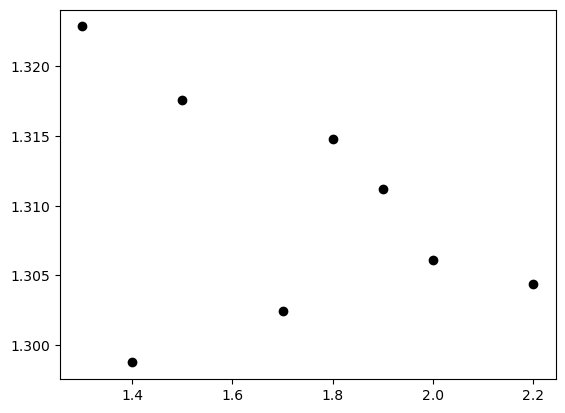

In [9]:
job_filter = {"remove_hydrogens": False, "remove_charges": False, "pressure": 0.0013933, "doc.n_runs": 2, "doc.equilibrated": True}
for kT, job in project.find_jobs(filter=job_filter).groupby("kT"):
    job = list(job)[0]
    if job.doc.equilibrated:
        try:
            print(kT, job.doc.avg_density)
            #print(kT, job.path)
            plt.plot(kT, job.doc.avg_density, "ko")
            #plt.vlines(x=1.67, ymin=0.68, ymax=0.72, ls="--", color="red")
        except:
            continue

In [10]:
for job in project:
    job.doc.msd_sampled = False

In [12]:
for job in project:
    print(job.doc.volume_sampled, job.doc.equilibrated)

True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
False False
True True
True True
True True
True True
True True
False False
False False
True True
True True
True True
False False
True True
True True
True True
True True
True True
True True
True True
True True
True True
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
